# Aligning Deep Exposures of Sparse Fields

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

# Introduction


This notebook demonstrates aligning long exposures which have relatively few stars and a large number of cosmic rays. It is based on the example described in the ISR linked here ([ACS ISR 2015-04: Basic Use of SExtractor Catalogs With TweakReg - I](http://www.stsci.edu/hst/acs/documents/isrs/isr1504.pdf)), but uses a much simpler methodology.


Rather than making use of external software (e.g. [SExtractor](http://www.astromatic.net/software/sextractor)) and going through the extra steps to create 'cosmic-ray cleaned' images for each visit, this notebook demonstrates new features in TweakReg designed to mitigate false detections.

TweakReg’s source finding task `imagefind` now includes parameters to exclude false detections and allow the software to more easily solve for the image offsets using matched sources lists. For example, `dqbits` is a list of DQ flag values to include as 'good' or to exclude as 'bad' before generating and matching source lists. For ACS/WFC, setting `dqbits=-16` will mask hot pixels flagged by the instrument team, eliminating a common problem where TweakReg locks onto hot pixels and solves for the dither pattern. This can occur when users set the detection threshold value too low and hot pixels outnumber astronomical sources. Other new parameters allow selection for sharpness and roundness, which give users better control over source selection criteria and the mitigation of artifacts. More details on imagefindpars options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/deployment/imagefindpars.html).

In [1]:
from astropy.table import Table
from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
import glob
import matplotlib.pyplot as plt
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle
from IPython.display import Image



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Download the Data

The data in this example are comprised of 4 exposures in the F814W filter, all from Visit 0X of HST program 10092. Each exposure was dithered by ~60 pixels along the y-axis in order to obtain coverage in the area of the CCD chip gap. The X and Y dithers are given in arcseconds by the `POSTARG1` and `POSTARG2` keywords recorded in the image header.

The following commands query MAST, download the calibrated, CTE-corrected FLC files, and place them in the same 'working' directory as this notebook. 

In [2]:
# Query MAST for the F814W files.
science_list = Observations.query_criteria(proposal_id='10092', filters='F814W', obs_id='j8xi0x*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLC'])

science_files = glob.glob('science/mastDownload/HST/*/*fits')
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './'+root)
shutil.rmtree('science/')

# 2. Inspect the image headers

In [3]:
collect = ImageFileCollection('./',
                              keywords=["asn_id", "detector", "filter2", "exptime", "postarg1", "postarg2"],
                              glob_include="*flc.fits", ext=0)
out_table = collect.summary
out_table

file,asn_id,detector,filter2,exptime,postarg1,postarg2
str44,str9,str3,str5,float64,float64,float64
hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits,J8XI0X010,WFC,F814W,507.0,0.062,-3.0518
hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits,J8XI0X010,WFC,F814W,507.0,0.31,0.023747
hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits,J8XI0X010,WFC,F814W,507.0,-0.062,3.0518
hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits,J8XI0X010,WFC,F814W,507.0,0.186,6.127347
j8xi0xs0q_flc.fits,J8XI0X010,WFC,F814W,507.0,0.062,-3.0518
j8xi0xs3q_flc.fits,J8XI0X010,WFC,F814W,507.0,0.31,0.023747
j8xi0xs6q_flc.fits,J8XI0X010,WFC,F814W,507.0,-0.062,3.0518
j8xi0xsaq_flc.fits,J8XI0X010,WFC,F814W,507.0,0.186,6.127347


# 3. TweakReg Alignment 

Use TweakReg to align the FLC frames based on sources in the image. The provided input list (`input_flc.list`) is used to align the frames in the specified order with `j8xi0xsaq_flc.fits` as the reference image. The parameter `conv_width` specifies the convolution kernel width in pixels, with recommended values ~2x the PSF FWHM for detecting point sources in the FLC frame. For ACS/WFC & WFC3/UVIS, this parameter is typically set to 3.5 pixels and for WFC3/IR to 2.5 pixels, but the value can be increased in order to use compact objects such as small galaxies for alignment.

## 3a. Use 'default' parameters (Test1)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:44:39.179 (14/08/2023) 


TweakReg Version 3.5.1 started at: 19:44:39.179 (14/08/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


INFO:drizzlepac.util:numpy Version -> 1.25.2 


numpy Version -> 1.25.2 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.8.0 


photutils Version -> 1.8.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakr

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:44:39.338 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:44:39.338 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.055177
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:40.277 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 8467 objects.


     Found 8467 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:44:40.399 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:44:40.399 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.991610
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:41.242 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 8501 objects.


     Found 8501 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 16968


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 16968


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:44:42.081 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:44:42.081 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.078989
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:42.950 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 6123 objects.


     Found 6123 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:44:43.066 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:44:43.066 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.974127
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:43.846 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 6119 objects.


     Found 6119 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 12242


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 12242


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:44:45.042 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:44:45.042 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.041938
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:45.764 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 4662 objects.


     Found 4662 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:44:45.857 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:44:45.857 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016332
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:46.729 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 4709 objects.


     Found 4709 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 9371


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 9371


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:44:47.903 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:44:47.903 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.523051
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:48.641 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 4919 objects.


     Found 4919 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:44:48.744 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:44:48.744 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.572939
INFO:drizzlepac.catalogs:###Source finding finished at: 19:44:49.507 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 5177 objects.


     Found 5177 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 10096


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 10096


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.4
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.1006, -0.2188 with significance of 18.53 and 385 matches


Found initial X and Y shifts of -0.1006, -0.2188 with significance of 18.53 and 385 matches


INFO:drizzlepac.imgclasses:Found 108 matches for j8xi0xs6q_flc.fits...


Found 108 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0991  YSH: -0.1297    ROT: 359.9994225    SCALE: 0.999943


XSH: -0.0991  YSH: -0.1297    ROT: 359.9994225    SCALE: 0.999943


INFO:drizzlepac.imgclasses:FIT XRMS: 0.39       FIT YRMS: 0.39   


FIT XRMS: 0.39       FIT YRMS: 0.39   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.55       FIT MAE: 0.47   


FIT RMSE: 0.55       FIT MAE: 0.47   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.3e-06 (deg)   RMS_DEC: 4.4e-06 (deg)


RMS_RA: 6.3e-06 (deg)   RMS_DEC: 4.4e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  108  objects.


Final solution based on  108  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 108


Total # points: 108


INFO:drizzlepac.tweakutils:# of points after clipping: 108


# of points after clipping: 108


INFO:drizzlepac.tweakutils:Total # points: 108


Total # points: 108


INFO:drizzlepac.tweakutils:# of points after clipping: 108


# of points after clipping: 108


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.4703, -0.1052 with significance of 16.14 and 302 matches


Found initial X and Y shifts of -0.4703, -0.1052 with significance of 16.14 and 302 matches


INFO:drizzlepac.imgclasses:Found 77 matches for j8xi0xs3q_flc.fits...


Found 77 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2067  YSH: 0.0854    ROT: 359.9988654    SCALE: 1.000048


XSH: -0.2067  YSH: 0.0854    ROT: 359.9988654    SCALE: 1.000048


INFO:drizzlepac.imgclasses:FIT XRMS: 0.46       FIT YRMS: 0.3    


FIT XRMS: 0.46       FIT YRMS: 0.3    


INFO:drizzlepac.imgclasses:FIT RMSE: 0.55       FIT MAE: 0.49   


FIT RMSE: 0.55       FIT MAE: 0.49   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.3e-06 (deg)   RMS_DEC: 5.6e-06 (deg)


RMS_RA: 5.3e-06 (deg)   RMS_DEC: 5.6e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  77  objects.


Final solution based on  77  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 77


Total # points: 77


INFO:drizzlepac.tweakutils:# of points after clipping: 77


# of points after clipping: 77


INFO:drizzlepac.tweakutils:Total # points: 77


Total # points: 77


INFO:drizzlepac.tweakutils:# of points after clipping: 77


# of points after clipping: 77


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1965, -7.899e-11 with significance of 15.25 and 305 matches


Found initial X and Y shifts of 0.1965, -7.899e-11 with significance of 15.25 and 305 matches


INFO:drizzlepac.imgclasses:Found 80 matches for j8xi0xs0q_flc.fits...


Found 80 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.1857  YSH: 0.1734    ROT: 0.000923387135    SCALE: 1.000027


XSH: 0.1857  YSH: 0.1734    ROT: 0.000923387135    SCALE: 1.000027


INFO:drizzlepac.imgclasses:FIT XRMS: 0.38       FIT YRMS: 0.29   


FIT XRMS: 0.38       FIT YRMS: 0.29   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.47       FIT MAE: 0.37   


FIT RMSE: 0.47       FIT MAE: 0.37   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.9e-06 (deg)   RMS_DEC: 4.4e-06 (deg)


RMS_RA: 4.9e-06 (deg)   RMS_DEC: 4.4e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  78  objects.


Final solution based on  78  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 78


Total # points: 78


INFO:drizzlepac.tweakutils:# of points after clipping: 78


# of points after clipping: 78


INFO:drizzlepac.tweakutils:Total # points: 78


Total # points: 78


INFO:drizzlepac.tweakutils:# of points after clipping: 78


# of points after clipping: 78


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test1.txt


Writing out shiftfile : shift814_flc_test1.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


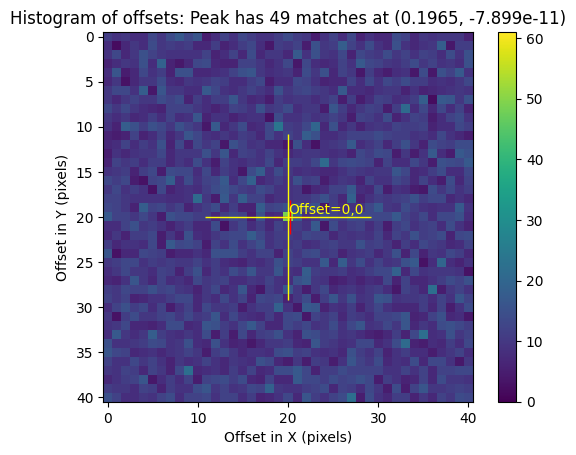

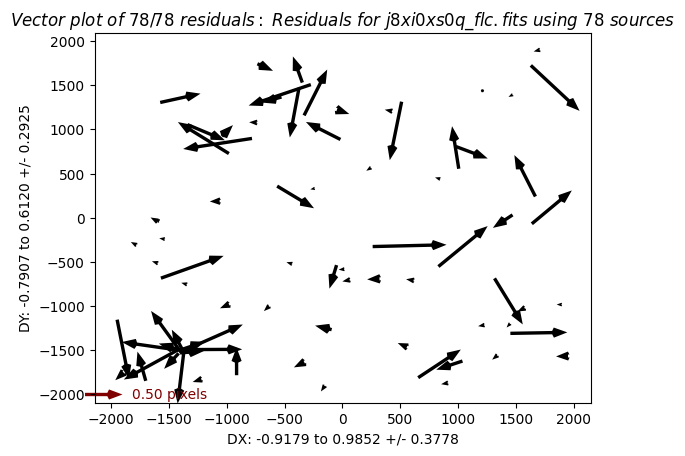

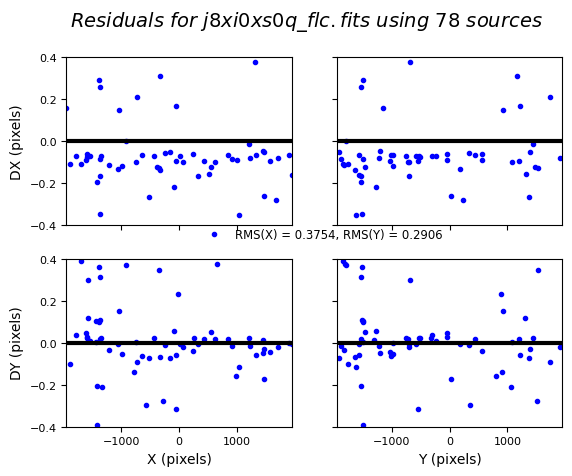

In [4]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100,'conv_width': 3.5},
                  shiftfile=True, outshifts='shift814_flc_test1.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

In [5]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test1_{}'.format(png)))
    os.rename(path, new_path)

To verify that TweakReg has found a good fit, it is important to inspect the fit residuals. Below are the dx,dy residuals for each FLC file with respect to the reference image `j8xi0xsaq_flc.fits`. TweakReg finds >100 matches per frame, but the RMS of the fit residuals is quite large, ~0.7 pixels, and the points are not nicely clustered around dx,dy=0.0, as expected for a good fit.

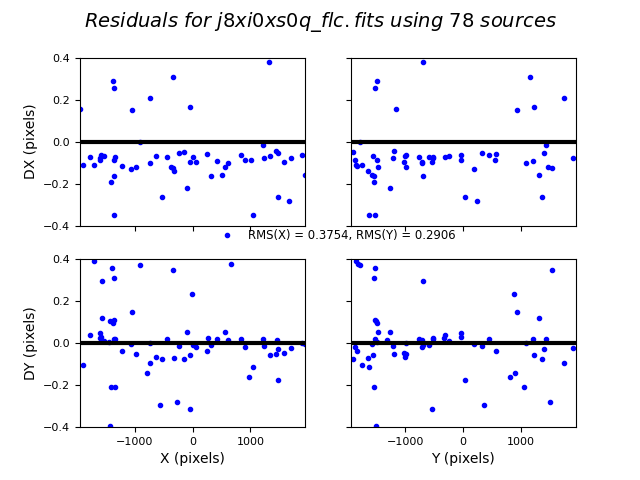

In [6]:
Image(filename='test1_residuals_j8xi0xs0q_flc.png')

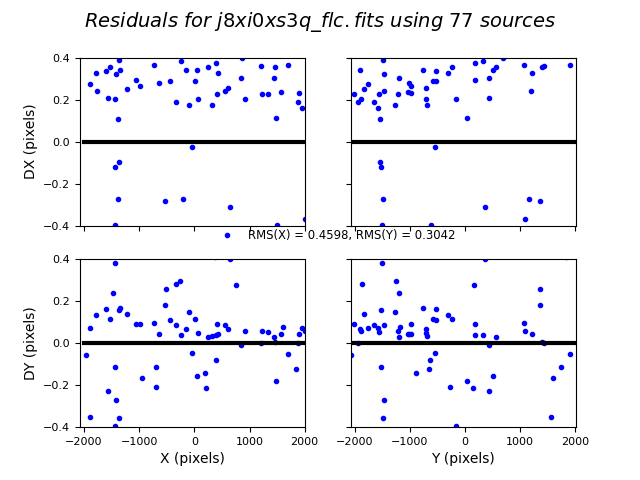

In [7]:
Image(filename='test1_residuals_j8xi0xs3q_flc.png')

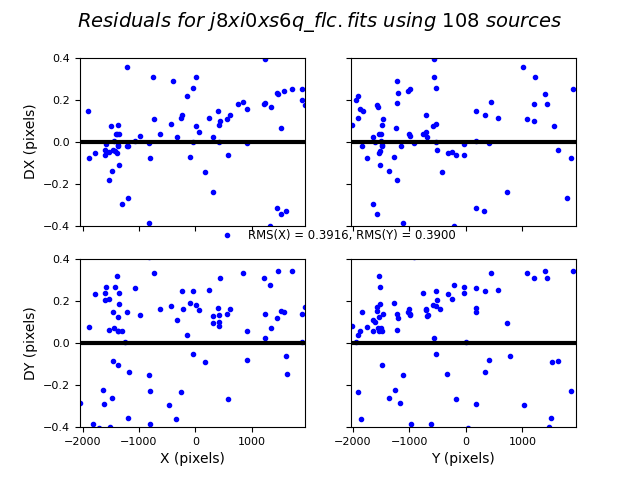

In [8]:
Image(filename='test1_residuals_j8xi0xs6q_flc.png')

In [9]:
# Inspect the shift file for Test1
shift_table = Table.read('shift814_flc_test1.txt', format='ascii.no_header',
               names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1: ]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str18,float64,float64,float64,float64,float64,float64
j8xi0xsaq_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
j8xi0xs6q_flc.fits,-0.10,-0.13,359.999,0.99994,0.39,0.39
j8xi0xs3q_flc.fits,-0.21,0.09,359.999,1.00005,0.46,0.30
j8xi0xs0q_flc.fits,0.19,0.17,0.001,1.00003,0.38,0.29


## 3b. Adjust `conv_width` to find extended objects (Test 2)

In order for TweakReg to use compact galaxies rather than point sources for alignment, we increase the convolution kernel width parameter `conv_width` from 3.5 to 6.0 pixels in order to find sources with a FWHM ~3 pixels in the FLC frames.

In [10]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0},
                  shiftfile=True, outshifts='shift814_flc_test2.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:45:02.690 (14/08/2023) 


TweakReg Version 3.5.1 started at: 19:45:02.690 (14/08/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


INFO:drizzlepac.util:numpy Version -> 1.25.2 


numpy Version -> 1.25.2 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.8.0 


photutils Version -> 1.8.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	6.0
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakr

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:45:02.865 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:45:02.865 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.055177
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:04.086 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 2702 objects.


     Found 2702 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:45:04.17 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:45:04.17 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.991610
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:05.239 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 2602 objects.


     Found 2602 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 5304


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 5304


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:45:06.048 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:45:06.048 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.078989
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:07.033 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1839 objects.


     Found 1839 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:45:07.114 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:45:07.114 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.974127
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:08.094 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1862 objects.


     Found 1862 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 3701


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 3701


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:45:08.666 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:45:08.666 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.041938
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:09.621 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1367 objects.


     Found 1367 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:45:09.699 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:45:09.699 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016332
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:10.677 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1396 objects.


     Found 1396 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 2763


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 2763


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:45:11.327 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:45:11.327 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.523051
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:12.307 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1486 objects.


     Found 1486 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:45:12.386 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:45:12.386 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.572939
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:13.351 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1523 objects.


     Found 1523 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 3009


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 3009


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.4
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2024, -0.02678 with significance of 34.92 and 89 matches


Found initial X and Y shifts of 0.2024, -0.02678 with significance of 34.92 and 89 matches


INFO:drizzlepac.imgclasses:Found 55 matches for j8xi0xs6q_flc.fits...


Found 55 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0037  YSH: 0.1000    ROT: 0.000118138184    SCALE: 1.000034


XSH: -0.0037  YSH: 0.1000    ROT: 0.000118138184    SCALE: 1.000034


INFO:drizzlepac.imgclasses:FIT XRMS: 0.11       FIT YRMS: 0.13   


FIT XRMS: 0.11       FIT YRMS: 0.13   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.17       FIT MAE: 0.11   


FIT RMSE: 0.17       FIT MAE: 0.11   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.1e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


RMS_RA: 2.1e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  46  objects.


Final solution based on  46  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 46


Total # points: 46


INFO:drizzlepac.tweakutils:# of points after clipping: 46


# of points after clipping: 46


INFO:drizzlepac.tweakutils:Total # points: 46


Total # points: 46


INFO:drizzlepac.tweakutils:# of points after clipping: 46


# of points after clipping: 46


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.005948, 0.1229 with significance of 31.42 and 71 matches


Found initial X and Y shifts of 0.005948, 0.1229 with significance of 31.42 and 71 matches


INFO:drizzlepac.imgclasses:Found 44 matches for j8xi0xs3q_flc.fits...


Found 44 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0924  YSH: 0.1465    ROT: 0.001324134339    SCALE: 1.000031


XSH: 0.0924  YSH: 0.1465    ROT: 0.001324134339    SCALE: 1.000031


INFO:drizzlepac.imgclasses:FIT XRMS: 0.051      FIT YRMS: 0.075  


FIT XRMS: 0.051      FIT YRMS: 0.075  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.091      FIT MAE: 0.067  


FIT RMSE: 0.091      FIT MAE: 0.067  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.1e-06 (deg)   RMS_DEC: 5.2e-07 (deg)


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 5.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  36  objects.


Final solution based on  36  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 36


Total # points: 36


INFO:drizzlepac.tweakutils:# of points after clipping: 36


# of points after clipping: 36


INFO:drizzlepac.tweakutils:Total # points: 36


Total # points: 36


INFO:drizzlepac.tweakutils:# of points after clipping: 36


# of points after clipping: 36


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.1609, -0.0284 with significance of 31.21 and 73 matches


Found initial X and Y shifts of -0.1609, -0.0284 with significance of 31.21 and 73 matches


INFO:drizzlepac.imgclasses:Found 45 matches for j8xi0xs0q_flc.fits...


Found 45 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0975  YSH: 0.1633    ROT: 0.001396493378    SCALE: 1.000017


XSH: 0.0975  YSH: 0.1633    ROT: 0.001396493378    SCALE: 1.000017


INFO:drizzlepac.imgclasses:FIT XRMS: 0.068      FIT YRMS: 0.06   


FIT XRMS: 0.068      FIT YRMS: 0.06   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.09       FIT MAE: 0.071  


FIT RMSE: 0.09       FIT MAE: 0.071  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.8e-07 (deg)   RMS_DEC: 7.8e-07 (deg)


RMS_RA: 9.8e-07 (deg)   RMS_DEC: 7.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  39  objects.


Final solution based on  39  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test2.txt


Writing out shiftfile : shift814_flc_test2.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


In [11]:
# Give the 'fit residual plots' a unique name for comparison with subsequent tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test2_{}'.format(png)))
    os.rename(path, new_path)


TweakReg now finds matches ~50 objects per frame, and the fit for the first matched image `j8xi0xs0q_flc.fits` looks good, with an RMS ~0.1 pixels and with the residuals dx,dy clustered around 0.0.  For the other two frames `j8xi0xs3q_flc.fits` and `j8xi0xs6q_flc.fits`, the RMS is ~0.2 pixels, and the points are not centered around dx,dy=0 pixels.

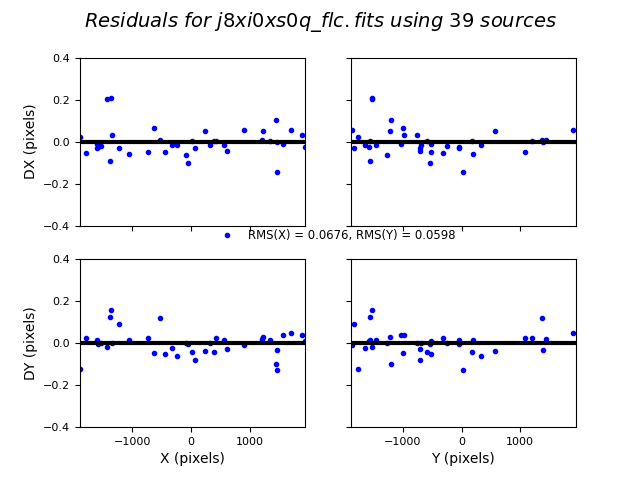

In [12]:
Image(filename='test2_residuals_j8xi0xs0q_flc.png')

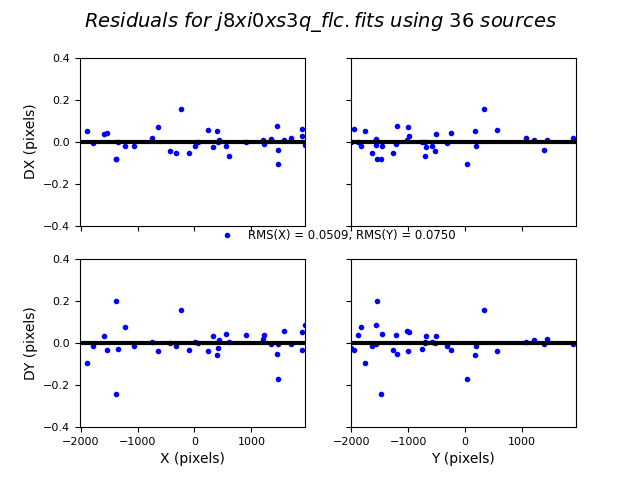

In [13]:
Image(filename='test2_residuals_j8xi0xs3q_flc.png')

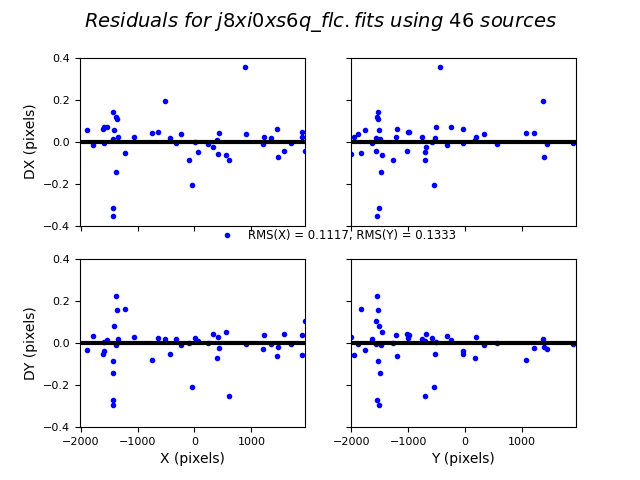

In [14]:
Image(filename='test2_residuals_j8xi0xs6q_flc.png')

In [15]:
# Inspect the shift file for Test2
shift_table = Table.read('shift814_flc_test2.txt', format='ascii.no_header', 
                       names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str18,float64,float64,float64,float64,float64,float64
j8xi0xsaq_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
j8xi0xs6q_flc.fits,-0.00,0.10,0.000,1.00003,0.11,0.13
j8xi0xs3q_flc.fits,0.09,0.15,0.001,1.00003,0.05,0.07
j8xi0xs0q_flc.fits,0.10,0.16,0.001,1.00002,0.07,0.06


## 3c. Exclude flagged pixels with `dqbits` (Test 3)

To further improve the alignment, we make use of flags in the DQ array of the FLC files. The source finding parameters in TweakReg may be modified to exclude flagged pixels when generating lists of objects in each image.

Setting the parameter `dqbits=0` will consider all non-zero pixels in the DQ mask to be “bad” pixels, and the corresponding image pixels will not be used for source finding. The default value of 'None' will turn off the use of image’s DQ array for source finding. In this case, AstroDrizzle was already run by MAST on visit 0X, and cosmic-ray flags were populated in the DQ array of the FLC frames. Since the exposures within this visit were already well aligned, the 4096 flags for cosmic rays are useful for excluding false detections.

In [16]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0, 'dqbits': 0},
                  shiftfile=True, outshifts='shift814_flc_test3.txt',
                  updatehdr=False, interactive=False, ylimit=0.4)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:45:18.058 (14/08/2023) 


TweakReg Version 3.5.1 started at: 19:45:18.058 (14/08/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


INFO:drizzlepac.util:numpy Version -> 1.25.2 


numpy Version -> 1.25.2 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.8.0 


photutils Version -> 1.8.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	6.0
INFO:drizzlepac.tweakreg:	dqbits :	0
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweak

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:45:18.260 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:45:18.260 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.055177
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:19.242 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1149 objects.


     Found 1149 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:45:19.332 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:45:19.332 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.991610
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:20.313 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 940 objects.


     Found 940 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2089


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2089


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:45:21.089 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:45:21.089 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.078989
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:22.060 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 757 objects.


     Found 757 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:45:22.151 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:45:22.151 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.974127
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:23.113 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 713 objects.


     Found 713 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1470


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1470


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:45:23.678 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:45:23.678 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.041938
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:24.644 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 624 objects.


     Found 624 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:45:24.741 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:45:24.741 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016332
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:25.715 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 544 objects.


     Found 544 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1168


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1168


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:45:26.156 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:45:26.156 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.523051
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:27.135 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 620 objects.


     Found 620 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:45:27.227 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:45:27.227 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.572939
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:28.187 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 622 objects.


     Found 622 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1242


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1242


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.4
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4377, -0.1161 with significance of 43.68 and 57 matches


Found initial X and Y shifts of 0.4377, -0.1161 with significance of 43.68 and 57 matches


INFO:drizzlepac.imgclasses:Found 51 matches for j8xi0xs6q_flc.fits...


Found 51 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0007  YSH: 0.1043    ROT: 0.0002371156048    SCALE: 1.000016


XSH: -0.0007  YSH: 0.1043    ROT: 0.0002371156048    SCALE: 1.000016


INFO:drizzlepac.imgclasses:FIT XRMS: 0.059      FIT YRMS: 0.074  


FIT XRMS: 0.059      FIT YRMS: 0.074  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.095      FIT MAE: 0.076  


FIT RMSE: 0.095      FIT MAE: 0.076  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 6.3e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 6.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  44  objects.


Final solution based on  44  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2918, 0.06694 with significance of 37.83 and 55 matches


Found initial X and Y shifts of 0.2918, 0.06694 with significance of 37.83 and 55 matches


INFO:drizzlepac.imgclasses:Found 44 matches for j8xi0xs3q_flc.fits...


Found 44 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0933  YSH: 0.1427    ROT: 0.001210361624    SCALE: 1.000030


XSH: 0.0933  YSH: 0.1427    ROT: 0.001210361624    SCALE: 1.000030


INFO:drizzlepac.imgclasses:FIT XRMS: 0.05       FIT YRMS: 0.076  


FIT XRMS: 0.05       FIT YRMS: 0.076  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.091      FIT MAE: 0.068  


FIT RMSE: 0.091      FIT MAE: 0.068  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 5e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 5e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  37  objects.


Final solution based on  37  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 37


Total # points: 37


INFO:drizzlepac.tweakutils:# of points after clipping: 37


# of points after clipping: 37


INFO:drizzlepac.tweakutils:Total # points: 37


Total # points: 37


INFO:drizzlepac.tweakutils:# of points after clipping: 37


# of points after clipping: 37


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.1499, -0.3232 with significance of 36.1 and 59 matches


Found initial X and Y shifts of -0.1499, -0.3232 with significance of 36.1 and 59 matches


INFO:drizzlepac.imgclasses:Found 41 matches for j8xi0xs0q_flc.fits...


Found 41 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0978  YSH: 0.1578    ROT: 0.001305751354    SCALE: 1.000016


XSH: 0.0978  YSH: 0.1578    ROT: 0.001305751354    SCALE: 1.000016


INFO:drizzlepac.imgclasses:FIT XRMS: 0.067      FIT YRMS: 0.059  


FIT XRMS: 0.067      FIT YRMS: 0.059  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.089      FIT MAE: 0.07   


FIT RMSE: 0.089      FIT MAE: 0.07   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.6e-07 (deg)   RMS_DEC: 7.8e-07 (deg)


RMS_RA: 9.6e-07 (deg)   RMS_DEC: 7.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  39  objects.


Final solution based on  39  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]
INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]
INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift814_flc_test3.txt


Writing out shiftfile : shift814_flc_test3.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


In [17]:
# Give the 'fit residual plots' a unique name for comparison with other tests.
residual_pngs = glob.glob("residual*png")
for png in residual_pngs: 
    path = os.path.abspath(os.path.join(os.curdir, png))
    new_path = os.path.abspath(os.path.join(os.curdir, 'test3_{}'.format(png)))
    os.rename(path, new_path)   

In this third test, TweakReg again finds ~40 matches per frame, but with spurious detections eliminated has an easier time locking onto the correct solution.  The fit residuals below all have an RMS ~0.1 pixels and the points are all clustered around dx,dy=0.

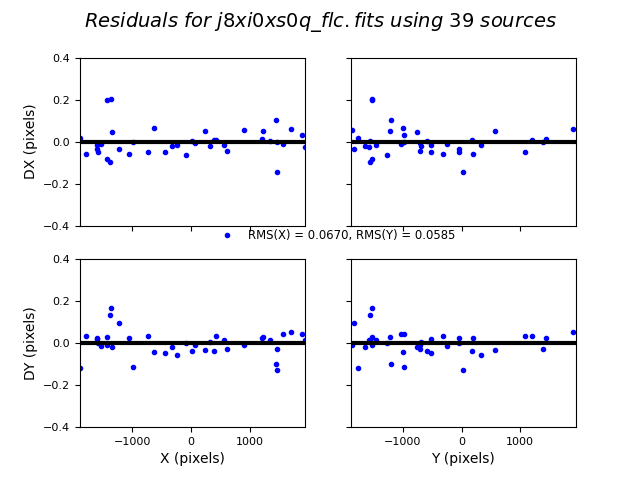

In [18]:
Image(filename='test3_residuals_j8xi0xs0q_flc.png')

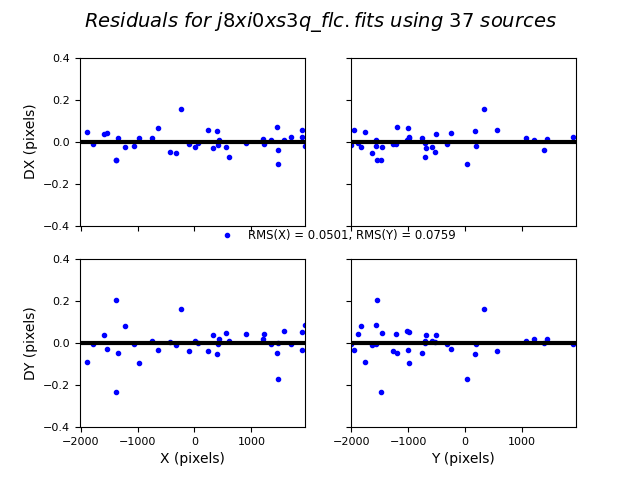

In [19]:
Image(filename='test3_residuals_j8xi0xs3q_flc.png')

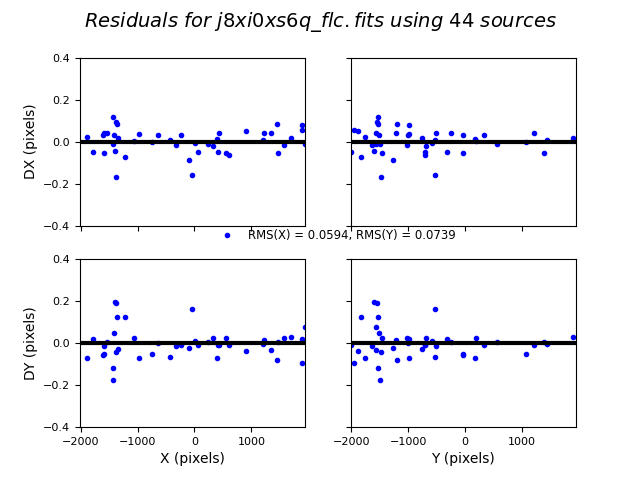

In [20]:
Image(filename='test3_residuals_j8xi0xs6q_flc.png')

In [21]:
# Inspect the shift file for Test2
shift_table = Table.read('shift814_flc_test3.txt', format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

file,dx,dy,rot,scale,xrms,yrms
str18,float64,float64,float64,float64,float64,float64
j8xi0xsaq_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
j8xi0xs6q_flc.fits,-0.00,0.10,0.000,1.00002,0.06,0.07
j8xi0xs3q_flc.fits,0.09,0.14,0.001,1.00003,0.05,0.08
j8xi0xs0q_flc.fits,0.10,0.16,0.001,1.00002,0.07,0.06


## 3d. Rerun TweakReg to update the header WCS

Now run TweakReg with `updatehdr=True` to update the image headers with this solution.

In [22]:
tweakreg.TweakReg('@input_flc.list',
                  imagefindcfg={'threshold': 100, 'conv_width': 6.0, 'dqbits': 0},
                  shiftfile=False, updatehdr=True, interactive=False)

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 19:45:32.378 (14/08/2023) 


TweakReg Version 3.5.1 started at: 19:45:32.378 (14/08/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]


INFO:drizzlepac.util:numpy Version -> 1.25.2 


numpy Version -> 1.25.2 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.8.0 


photutils Version -> 1.8.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:j8xi0xsaq_flc.fits   


j8xi0xsaq_flc.fits   


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    j8xi0xsaq_flc.fits


    j8xi0xsaq_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs6q_flc.fits


    j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs3q_flc.fits


    j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:    j8xi0xs0q_flc.fits


    j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	6.0
INFO:drizzlepac.tweakreg:	dqbits :	0
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@input_flc.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweak

===  Source finding for image 'j8xi0xsaq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:45:32.755 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 1) started at: 19:45:32.755 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.055177
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:33.753 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 1149 objects.


     Found 1149 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:45:33.846 (14/08/2023)


  #  Source finding for 'j8xi0xsaq_flc.fits', EXT=('SCI', 2) started at: 19:45:33.846 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.991610
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:34.82 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 940 objects.


     Found 940 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2089


===  FINAL number of objects in image 'j8xi0xsaq_flc.fits': 2089


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs6q_flc.fits':


===  Source finding for image 'j8xi0xs6q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:45:35.446 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 1) started at: 19:45:35.446 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.078989
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:36.420 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 757 objects.


     Found 757 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:45:36.511 (14/08/2023)


  #  Source finding for 'j8xi0xs6q_flc.fits', EXT=('SCI', 2) started at: 19:45:36.511 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.974127
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:37.486 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 713 objects.


     Found 713 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1470


===  FINAL number of objects in image 'j8xi0xs6q_flc.fits': 1470


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs3q_flc.fits':


===  Source finding for image 'j8xi0xs3q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:45:38.089 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 1) started at: 19:45:38.089 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.041938
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:39.060 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 624 objects.


     Found 624 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:45:39.152 (14/08/2023)


  #  Source finding for 'j8xi0xs3q_flc.fits', EXT=('SCI', 2) started at: 19:45:39.152 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.016332
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:40.145 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 544 objects.


     Found 544 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1168


===  FINAL number of objects in image 'j8xi0xs3q_flc.fits': 1168


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j8xi0xs0q_flc.fits':


===  Source finding for image 'j8xi0xs0q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:45:40.633 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 1) started at: 19:45:40.633 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.523051
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:41.630 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 620 objects.


     Found 620 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:45:41.726 (14/08/2023)


  #  Source finding for 'j8xi0xs0q_flc.fits', EXT=('SCI', 2) started at: 19:45:41.726 (14/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 10.572939
INFO:drizzlepac.catalogs:###Source finding finished at: 19:45:42.877 (14/08/2023)
INFO:drizzlepac.catalogs:     Found 622 objects.


     Found 622 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1242


===  FINAL number of objects in image 'j8xi0xs0q_flc.fits': 1242


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j8xi0xsaq_flc.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j8xi0xsaq_flc.fits'


derived from 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	None
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs6q_flc.fits


Performing fit for: j8xi0xs6q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs6q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4377, -0.1161 with significance of 43.68 and 57 matches


Found initial X and Y shifts of 0.4377, -0.1161 with significance of 43.68 and 57 matches


INFO:drizzlepac.imgclasses:Found 51 matches for j8xi0xs6q_flc.fits...


Found 51 matches for j8xi0xs6q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


Computed  rscale  fit for  j8xi0xs6q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0007  YSH: 0.1043    ROT: 0.0002371156048    SCALE: 1.000016


XSH: -0.0007  YSH: 0.1043    ROT: 0.0002371156048    SCALE: 1.000016


INFO:drizzlepac.imgclasses:FIT XRMS: 0.059      FIT YRMS: 0.074  


FIT XRMS: 0.059      FIT YRMS: 0.074  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.095      FIT MAE: 0.076  


FIT RMSE: 0.095      FIT MAE: 0.076  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 6.3e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 6.3e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  44  objects.


Final solution based on  44  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs6q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs6q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.tweakutils:Total # points: 44


Total # points: 44


INFO:drizzlepac.tweakutils:# of points after clipping: 44


# of points after clipping: 44


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs6q_flc.fits' ...


....Updating header for 'j8xi0xs6q_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',1]


Processing j8xi0xs6q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[1]


Updating header for j8xi0xs6q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8080124020260445e-06 1.3843951623114113e-05


CD_11  CD_12: 2.8080124020260445e-06 1.3843951623114113e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.355680009682568e-05 -1.8859714774256836e-06


CD_21  CD_22: 1.355680009682568e-05 -1.8859714774256836e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18741686893645 2.6787647809321555


CRVAL    : 150.18741686893645 2.6787647809321555


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049841208478234804


Plate Scale : 0.049841208478234804


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.75768928436942


ORIENTAT : 97.75768928436942


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs6q_flc.fits['SCI',2]


Processing j8xi0xs6q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs6q_flc.fits[4]


Updating header for j8xi0xs6q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9544973700619497e-06 1.3395587220909087e-05


CD_11  CD_12: 2.9544973700619497e-06 1.3395587220909087e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3359981273965333e-05 -1.7212045160430053e-06


CD_21  CD_22: 1.3359981273965333e-05 -1.7212045160430053e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21606800075705 2.674926333917868


CRVAL    : 150.21606800075705 2.674926333917868


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04925876005314109


Plate Scale : 0.04925876005314109


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.32184017067897


ORIENTAT : 97.32184017067897


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs3q_flc.fits


Performing fit for: j8xi0xs3q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs3q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2918, 0.06694 with significance of 37.83 and 55 matches


Found initial X and Y shifts of 0.2918, 0.06694 with significance of 37.83 and 55 matches


INFO:drizzlepac.imgclasses:Found 44 matches for j8xi0xs3q_flc.fits...


Found 44 matches for j8xi0xs3q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


Computed  rscale  fit for  j8xi0xs3q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0933  YSH: 0.1427    ROT: 0.001210361624    SCALE: 1.000030


XSH: 0.0933  YSH: 0.1427    ROT: 0.001210361624    SCALE: 1.000030


INFO:drizzlepac.imgclasses:FIT XRMS: 0.05       FIT YRMS: 0.076  


FIT XRMS: 0.05       FIT YRMS: 0.076  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.091      FIT MAE: 0.068  


FIT RMSE: 0.091      FIT MAE: 0.068  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 5e-07 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 5e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  37  objects.


Final solution based on  37  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs3q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs3q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 37


Total # points: 37


INFO:drizzlepac.tweakutils:# of points after clipping: 37


# of points after clipping: 37


INFO:drizzlepac.tweakutils:Total # points: 37


Total # points: 37


INFO:drizzlepac.tweakutils:# of points after clipping: 37


# of points after clipping: 37


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs3q_flc.fits' ...


....Updating header for 'j8xi0xs3q_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',1]


Processing j8xi0xs3q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[1]


Updating header for j8xi0xs3q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8080798324594052e-06 1.3844238677491533e-05


CD_11  CD_12: 2.8080798324594052e-06 1.3844238677491533e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3557051226571646e-05 -1.8860299819367444e-06


CD_21  CD_22: 1.3557051226571646e-05 -1.8860299819367444e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18823958071715 2.678552610704514


CRVAL    : 150.18823958071715 2.678552610704514


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04984285556486401


Plate Scale : 0.04984285556486401


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.75776810577521


ORIENTAT : 97.75776810577521


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs3q_flc.fits['SCI',2]


Processing j8xi0xs3q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs3q_flc.fits[4]


Updating header for j8xi0xs3q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9545676859013888e-06 1.3395865083140503e-05


CD_11  CD_12: 2.9545676859013888e-06 1.3395865083140503e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3360228417772082e-05 -1.7212591763273497e-06


CD_21  CD_22: 1.3360228417772082e-05 -1.7212591763273497e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21689130167675 2.6747140438228687


CRVAL    : 150.21689130167675 2.6747140438228687


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04926038769385816


Plate Scale : 0.04926038769385816


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.32191993795642


ORIENTAT : 97.32191993795642


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: j8xi0xs0q_flc.fits


Performing fit for: j8xi0xs0q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


Matching sources from 'j8xi0xs0q_flc.fits' with sources from reference image 'j8xi0xsaq_flc.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.1499, -0.3232 with significance of 36.1 and 59 matches


Found initial X and Y shifts of -0.1499, -0.3232 with significance of 36.1 and 59 matches


INFO:drizzlepac.imgclasses:Found 41 matches for j8xi0xs0q_flc.fits...


Found 41 matches for j8xi0xs0q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


Computed  rscale  fit for  j8xi0xs0q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0978  YSH: 0.1578    ROT: 0.001305751354    SCALE: 1.000016


XSH: 0.0978  YSH: 0.1578    ROT: 0.001305751354    SCALE: 1.000016


INFO:drizzlepac.imgclasses:FIT XRMS: 0.067      FIT YRMS: 0.059  


FIT XRMS: 0.067      FIT YRMS: 0.059  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.089      FIT MAE: 0.07   


FIT RMSE: 0.089      FIT MAE: 0.07   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 9.6e-07 (deg)   RMS_DEC: 7.8e-07 (deg)


RMS_RA: 9.6e-07 (deg)   RMS_DEC: 7.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  39  objects.


Final solution based on  39  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j8xi0xs0q_flc_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


wrote XY data to:  j8xi0xs0q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.tweakutils:Total # points: 39


Total # points: 39


INFO:drizzlepac.tweakutils:# of points after clipping: 39


# of points after clipping: 39


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'j8xi0xs0q_flc.fits' ...


....Updating header for 'j8xi0xs0q_flc.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',1]


Processing j8xi0xs0q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[1]


Updating header for j8xi0xs0q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8081429417928826e-06 1.3844573768526206e-05


CD_11  CD_12: 2.8081429417928826e-06 1.3844573768526206e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3557373211216611e-05 -1.8860729824857248e-06


CD_21  CD_22: 1.3557373211216611e-05 -1.8860729824857248e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.189096634702 2.6785083038088517


CRVAL    : 150.189096634702 2.6785083038088517


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04984330499937501


Plate Scale : 0.04984330499937501


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.75775734015073


ORIENTAT : 97.75775734015073


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j8xi0xs0q_flc.fits['SCI',2]


Processing j8xi0xs0q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xs0q_flc.fits[4]


Updating header for j8xi0xs0q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.954634403429044e-06 1.339618928861542e-05


CD_11  CD_12: 2.954634403429044e-06 1.339618928861542e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3360545747437395e-05 -1.7212983083467805e-06


CD_21  CD_22: 1.3360545747437395e-05 -1.7212983083467805e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.2177490481021 2.674669649492529


CRVAL    : 150.2177490481021 2.674669649492529


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049260831831605234


Plate Scale : 0.049260831831605234


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.32190931079418


ORIENTAT : 97.32190931079418


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing j8xi0xsaq_flc.fits['SCI',1]


Processing j8xi0xsaq_flc.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xsaq_flc.fits[('SCI', 1)]


Updating header for j8xi0xsaq_flc.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.8079967919903e-06 1.3843808144676e-05


CD_11  CD_12: 2.8079967919903e-06 1.3843808144676e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3556667817249e-05 -1.885962398673e-06


CD_21  CD_22: 1.3556667817249e-05 -1.885962398673e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.18656016383 2.6788087056098


CRVAL    : 150.18656016383 2.6788087056098


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.04983992801210863


Plate Scale : 0.04983992801210863


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.7577318168269


ORIENTAT : 97.7577318168269


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing j8xi0xsaq_flc.fits['SCI',2]


Processing j8xi0xsaq_flc.fits['SCI',2]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for j8xi0xsaq_flc.fits[('SCI', 2)]


Updating header for j8xi0xsaq_flc.fits[('SCI', 2)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 2.9544800665701e-06 1.33954484758e-05


CD_11  CD_12: 2.9544800665701e-06 1.33954484758e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.3359850787753e-05 -1.7211967597822e-06


CD_21  CD_22: 1.3359850787753e-05 -1.7211967597822e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 150.21521099973 2.6749702767348


CRVAL    : 150.21521099973 2.6749702767348


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0


CRPIX    : 2048.0 1024.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048


NAXIS    : 4096 2048


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049257494549873396


Plate Scale : 0.049257494549873396


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 97.32188254795771


ORIENTAT : 97.32188254795771


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


# 4. Drizzle the aligned frames

Combine the aligned FLC files with AstroDrizzle. The ACS team now corrects for stable hot pixels (DQ flag=16) via the dark reference files, so these pixels can be considered 'good'. Full well saturated pixels (DQ flag=256) and warm pixels (DQ flag=64) may also be treated as good. More details on the recommended drizzle parameters for ACS may be found in [ISR 2017-02](http://www.stsci.edu/hst/acs/documents/isrs/isr1702.pdf).

In [23]:
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f814w',
                          preserve=False,
                          clean=True,
                          build=False,
                          context=False,
                          driz_sep_bits='256,64,16',
                          combine_type='median',
                          final_bits='256,64,16',
                          runfile='f814w_driz.log')

INFO:drizzlepac.util:Setting up logfile :  f814w_driz.log


Setting up logfile :  f814w_driz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: f814w_driz.log


AstroDrizzle log file: f814w_driz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 19:45:48.606 (14/08/2023)


AstroDrizzle Version 3.5.1 started at: 19:45:48.606 (14/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.11.4 (main, Jun  7 2023, 11:01:02) [GCC 11.3.0]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.25.2 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.8.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  19:45:48.61 (14/08/2023)


==== Processing Step  Initialization  started at  19:45:48.61 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f814w_drc.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.086336389325649
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.086336389325649
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.3231692580153933
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.3231692580153933
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.5969384266216954
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.5969384266216954
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 55.5302848815918
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 55.5302848815918
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.70519256591797
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 50.7051925659

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20205736356377  2.6769790254265815  


CRVAL : 150.20205736356377  2.6769790254265815  


INFO:astropy.wcs.wcs:CRPIX : 2111.5  2211.0  


CRPIX : 2111.5  2211.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116107294376303e-06  1.367791534765304e-05  


CD1_1 CD1_2  : 2.4116107294376303e-06  1.367791534765304e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.367791534765304e-05  -2.4116107294376303e-06  


CD2_1 CD2_2  : 1.367791534765304e-05  -2.4116107294376303e-06  


INFO:astropy.wcs.wcs:NAXIS : 4223  4422


NAXIS : 4223  4422


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 555 Mb.


*  Estimated memory usage:  up to 555 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4223 X 4422 pixels. 


*  Output image size:       4223 X 4422 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 213 Mb. 


*  Output image file:       ~ 213 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         2


*  Cores available:         2


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 19:45:54.00 (14/08/2023)


==== Processing Step Initialization finished at 19:45:54.00 (14/08/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	False
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flc.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f814w
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	f814w_driz.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  19:45:54.018 (14/08/2023)


==== Processing Step  Static Mask  started at  19:45:54.018 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 54.979943;   rms = 10.974079;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 54.496145;   rms = 9.851141;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 50.439763;   rms = 10.696259;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 49.727100;   rms = 9.592484;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 50.944256;   rms = 10.822448;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 50.298722;   rms = 9.625347;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 50.497218;   rms = 11.489359;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 49.

==== Processing Step Static Mask finished at 19:45:58.889 (14/08/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  19:45:58.892 (14/08/2023)


==== Processing Step  Subtract Sky  started at  19:45:58.892 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	localmin
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-08-14 19:45:59.945229


***** skymatch started on 2023-08-14 19:45:59.945229


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits'


   **  Input image: 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs0q_flc.fits'


   **  Input image: 'j8xi0xs0q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs0q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs0q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs3q_flc.fits'


   **  Input image: 'j8xi0xs3q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs3q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs3q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs3q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs3q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xs6q_flc.fits'


   **  Input image: 'j8xi0xs6q_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xs6q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xs6q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xs6q_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xs6q_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'j8xi0xsaq_flc.fits'


   **  Input image: 'j8xi0xsaq_flc.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: j8xi0xsaq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: j8xi0xsaq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:       EXT: 'SCI',2;	MASK: j8xi0xsaq_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',2;	MASK: j8xi0xsaq_skymatch_mask_sci2.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits


   *   Image: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs0q_flc.fits


   *   Image: j8xi0xs0q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs3q_flc.fits


   *   Image: j8xi0xs3q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xs6q_flc.fits


   *   Image: j8xi0xs6q_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: j8xi0xsaq_flc.fits


   *   Image: j8xi0xsaq_flc.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:       EXT = 'SCI',2


       EXT = 'SCI',2


INFO:stsci.skypac.utils:             Data units type: COUNTS


             Data units type: COUNTS


INFO:stsci.skypac.utils:             EXPTIME: 507.0 [s]


             EXPTIME: 507.0 [s]


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  0.7889546351084812


             Conversion factor (data->brightness):  0.7889546351084812


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits['SCI',1,2]'  --  SKY = 43.810875646226265 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits['SCI',1,2]'  --  SKY = 43.810875646226265 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


      - EXT = 'SCI',1   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


      - EXT = 'SCI',2   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits['SCI',1,2]'  --  SKY = 40.004096698949084 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits['SCI',1,2]'  --  SKY = 40.004096698949084 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits['SCI',1,2]'  --  SKY = 40.13959594967332 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits['SCI',1,2]'  --  SKY = 40.13959594967332 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


INFO:stsci.skypac.utils:   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits['SCI',1,2]'  --  SKY = 39.66748841415495 (brightness units)


   *   Image:   'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits['SCI',1,2]'  --  SKY = 39.66748841415495 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs0q_flc.fits['SCI',1,2]'  --  SKY = 43.810875646226265 (brightness units)


   *   Image:   'j8xi0xs0q_flc.fits['SCI',1,2]'  --  SKY = 43.810875646226265 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


      - EXT = 'SCI',1   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


      - EXT = 'SCI',2   delta(MDRIZSKY) = 55.5303   NEW MDRIZSKY = 55.5303


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs3q_flc.fits['SCI',1,2]'  --  SKY = 40.004096698949084 (brightness units)


   *   Image:   'j8xi0xs3q_flc.fits['SCI',1,2]'  --  SKY = 40.004096698949084 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.7052   NEW MDRIZSKY = 50.7052


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xs6q_flc.fits['SCI',1,2]'  --  SKY = 40.13959594967332 (brightness units)


   *   Image:   'j8xi0xs6q_flc.fits['SCI',1,2]'  --  SKY = 40.13959594967332 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.8769   NEW MDRIZSKY = 50.8769


INFO:stsci.skypac.utils:   *   Image:   'j8xi0xsaq_flc.fits['SCI',1,2]'  --  SKY = 39.66748841415495 (brightness units)


   *   Image:   'j8xi0xsaq_flc.fits['SCI',1,2]'  --  SKY = 39.66748841415495 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


      - EXT = 'SCI',1   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


INFO:stsci.skypac.utils:      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


      - EXT = 'SCI',2   delta(MDRIZSKY) = 50.2785   NEW MDRIZSKY = 50.2785


INFO:stsci.skypac.utils:***** skymatch ended on 2023-08-14 19:46:07.834579


***** skymatch ended on 2023-08-14 19:46:07.834579


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:07.889350


TOTAL RUN TIME: 0:00:07.889350


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 19:46:08.47 (14/08/2023)


==== Processing Step Subtract Sky finished at 19:46:08.47 (14/08/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  19:46:08.477 (14/08/2023)


==== Processing Step  Separate Drizzle  started at  19:46:08.477 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 336, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzl

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20205736356377  2.6769790254265815  


CRVAL : 150.20205736356377  2.6769790254265815  


INFO:astropy.wcs.wcs:CRPIX : 2111.5  2211.0  


CRPIX : 2111.5  2211.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116107294376303e-06  1.367791534765304e-05  


CD1_1 CD1_2  : 2.4116107294376303e-06  1.367791534765304e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.367791534765304e-05  -2.4116107294376303e-06  


CD2_1 CD2_2  : 1.367791534765304e-05  -2.4116107294376303e-06  


INFO:astropy.wcs.wcs:NAXIS : 4223  4422


NAXIS : 4223  4422


INFO:drizzlepac.adrizzle:Executing 2 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.705193 to hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 55.530285 to hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.

-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits
  warnings.warn(



-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_wht.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_single_wht.fits
Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.278542 to hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.876938 to hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 50.278542 to hst_10092_

-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_wht.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_wht.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.705193 to j8xi0xs3q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 55.530285 to j8xi0xs0q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs0q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs3q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 55.530285 to j8xi0xs0q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 50.705193 to j8xi0xs3q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate

-Generating simple FITS output: j8xi0xs0q_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_single_sci.fits


-Generating simple FITS output: j8xi0xs3q_single_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_single_sci.fits


Writing out image to disk: j8xi0xs0q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_single_wht.fits
INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_single_sci.fits


Writing out image to disk: j8xi0xs3q_single_sci.fits
Writing out image to disk: j8xi0xs0q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_single_wht.fits


Writing out image to disk: j8xi0xs3q_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.876938 to j8xi0xs6q_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 50.278542 to j8xi0xsaq_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xsaq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:-Drizzle input: j8xi0xs6q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 50.278542 to j8xi0xsaq_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 50.876938 to j8xi0xs6q_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate

-Generating simple FITS output: j8xi0xsaq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_single_sci.fits


-Generating simple FITS output: j8xi0xs6q_single_sci.fits


  warnings.warn(

  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_single_sci.fits


Writing out image to disk: j8xi0xsaq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_single_sci.fits


Writing out image to disk: j8xi0xs6q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_single_wht.fits


Writing out image to disk: j8xi0xsaq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_single_wht.fits


Writing out image to disk: j8xi0xs6q_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 19:46:20.818 (14/08/2023)


==== Processing Step Separate Drizzle finished at 19:46:20.818 (14/08/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  19:46:20.821 (14/08/2023)


==== Processing Step  Create Median  started at  19:46:20.821 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	median
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits' is 55.5302848815918


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits' is 55.5302848815918


INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits' is 50.70519256591797


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits' is 50.70519256591797


INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits' is 50.87693786621094


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits' is 50.87693786621094


INFO:drizzlepac.createMedian:reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits' is 50.278541564941406


reference sky value for image 'hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits' is 50.278541564941406


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs0q_flc.fits' is 55.5302848815918


reference sky value for image 'j8xi0xs0q_flc.fits' is 55.5302848815918


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs3q_flc.fits' is 50.70519256591797


reference sky value for image 'j8xi0xs3q_flc.fits' is 50.70519256591797


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xs6q_flc.fits' is 50.87693786621094


reference sky value for image 'j8xi0xs6q_flc.fits' is 50.87693786621094


INFO:drizzlepac.createMedian:reference sky value for image 'j8xi0xsaq_flc.fits' is 50.278541564941406


reference sky value for image 'j8xi0xsaq_flc.fits' is 50.278541564941406


  _combine(arrays, out, nlow, nhigh, badmasks, funcstr)

INFO:drizzlepac.createMedian:Saving output median image to: 'f814w_med.fits'


Saving output median image to: 'f814w_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 19:46:29.554 (14/08/2023)


==== Processing Step Create Median finished at 19:46:29.554 (14/08/2023)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  19:46:29.557 (14/08/2023)


==== Processing Step  Blot  started at  19:46:29.557 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 55.530285 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 55.530285 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.705193 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.705193 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.876938 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.876938 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.278542 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]


    Blot: creating blotted image:  hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.278542 to blotted image hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


-Generating simple FITS output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


Writing out image to disk: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_blt.fits


  warnings.warn(

INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 55.530285 to blotted image j8xi0xs0q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs0q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_sci1_blt.fits


Writing out image to disk: j8xi0xs0q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs0q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 55.530285 to blotted image j8xi0xs0q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs0q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs0q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs0q_sci2_blt.fits


Writing out image to disk: j8xi0xs0q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.705193 to blotted image j8xi0xs3q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs3q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_sci1_blt.fits


Writing out image to disk: j8xi0xs3q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs3q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.705193 to blotted image j8xi0xs3q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs3q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs3q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs3q_sci2_blt.fits


Writing out image to disk: j8xi0xs3q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.876938 to blotted image j8xi0xs6q_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_sci1_blt.fits


-Generating simple FITS output: j8xi0xs6q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_sci1_blt.fits


Writing out image to disk: j8xi0xs6q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xs6q_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.876938 to blotted image j8xi0xs6q_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xs6q_sci2_blt.fits


-Generating simple FITS output: j8xi0xs6q_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xs6q_sci2_blt.fits


Writing out image to disk: j8xi0xs6q_sci2_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,1]


    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.278542 to blotted image j8xi0xsaq_flc.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_sci1_blt.fits


-Generating simple FITS output: j8xi0xsaq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_sci1_blt.fits


Writing out image to disk: j8xi0xsaq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,2]


    Blot: creating blotted image:  j8xi0xsaq_flc.fits[sci,2]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 50.278542 to blotted image j8xi0xsaq_flc.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j8xi0xsaq_sci2_blt.fits


-Generating simple FITS output: j8xi0xsaq_sci2_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: j8xi0xsaq_sci2_blt.fits


Writing out image to disk: j8xi0xsaq_sci2_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 19:47:02.781 (14/08/2023)


==== Processing Step Blot finished at 19:47:02.781 (14/08/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  19:47:02.783 (14/08/2023)


==== Processing Step  Driz_CR  started at  19:47:02.783 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 2 parallel workers
INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci1_crmask.fits
Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xs6_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_crmask.fits


Creating output: hst_10092_0x_acs_wfc_f814w_j8xi0xsa_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs0q_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output: j8xi0xs3q_sci1_crmask.fits


Creating output: j8xi0xs0q_sci1_crmask.fits
Creating output: j8xi0xs3q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs0q_sci2_crmask.fits


Creating output: j8xi0xs0q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs3q_sci2_crmask.fits


Creating output: j8xi0xs3q_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xsaq_sci1_crmask.fits


Creating output: j8xi0xsaq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs6q_sci1_crmask.fits


Creating output: j8xi0xs6q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xsaq_sci2_crmask.fits


Creating output: j8xi0xsaq_sci2_crmask.fits


INFO:drizzlepac.drizCR:Creating output: j8xi0xs6q_sci2_crmask.fits


Creating output: j8xi0xs6q_sci2_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 19:47:19.9 (14/08/2023)


==== Processing Step Driz_CR finished at 19:47:19.9 (14/08/2023)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  19:47:19.9 (14/08/2023)


==== Processing Step  Final Drizzle  started at  19:47:19.9 (14/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 336, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	f814w_driz.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 150.20205736356377  2.6769790254265815  


CRVAL : 150.20205736356377  2.6769790254265815  


INFO:astropy.wcs.wcs:CRPIX : 2111.5  2211.0  


CRPIX : 2111.5  2211.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.4116107294376303e-06  1.367791534765304e-05  


CD1_1 CD1_2  : 2.4116107294376303e-06  1.367791534765304e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 1.367791534765304e-05  -2.4116107294376303e-06  


CD2_1 CD2_2  : 1.367791534765304e-05  -2.4116107294376303e-06  


INFO:astropy.wcs.wcs:NAXIS : 4223  4422


NAXIS : 4223  4422


INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 55.530285 to hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.adrizzle:Applying sky value of 55.530285 to hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits[sci,2]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits[sci,1]
INFO:dr

-Generating simple FITS output: f814w_drc_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f814w_drc_sci.fits


Writing out image to disk: f814w_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f814w_drc_wht.fits


Writing out image to disk: f814w_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 19:48:10.284 (14/08/2023)


==== Processing Step Final Drizzle finished at 19:48:10.284 (14/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 19:48:10.290 (14/08/2023).


AstroDrizzle Version 3.5.1 is finished processing at 19:48:10.290 (14/08/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          5.3949 sec.


         Initialization          5.3949 sec.


INFO:drizzlepac.util:            Static Mask          4.8706 sec.


            Static Mask          4.8706 sec.


INFO:drizzlepac.util:           Subtract Sky          9.5820 sec.


           Subtract Sky          9.5820 sec.


INFO:drizzlepac.util:       Separate Drizzle          12.3407 sec.


       Separate Drizzle          12.3407 sec.


INFO:drizzlepac.util:          Create Median          8.7332 sec.


          Create Median          8.7332 sec.


INFO:drizzlepac.util:                   Blot          33.2239 sec.


                   Blot          33.2239 sec.


INFO:drizzlepac.util:                Driz_CR          17.1562 sec.


                Driz_CR          17.1562 sec.


INFO:drizzlepac.util:          Final Drizzle          50.3282 sec.


          Final Drizzle          50.3282 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          141.6297 sec.


                  Total          141.6297 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xs0_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xs3_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xs6_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for hst_10092_0x_acs_wfc_f814w_j8xi0xsa_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs0q_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs3q_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xs6q_flc.fits
INFO:drizzlepac.imageObject:Removing intermediate files for j8xi0xsaq_flc.fits
INFO:drizzlepac.util:Trailer file written to:  f814w_driz.log


Trailer file written to:  f814w_driz.log


# 5. Display the original FLC image and the combined DRC data

In [24]:
sci2 = fits.getdata('j8xi0xsaq_flc.fits', ('sci', 2))
sci1 = fits.getdata('j8xi0xsaq_flc.fits', ('sci', 1))

fig = plt.figure(figsize=(50, 50))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(1, 2, 1)

ax1.imshow(sci2, vmin=50, vmax=100, cmap='Greys_r', origin='lower')
ax2.imshow(sci1, vmin=50, vmax=100, cmap='Greys_r', origin='lower')

In [25]:
sci = fits.getdata('f814w_drc_sci.fits')
fig = plt.figure(figsize=(20, 20))
plt.imshow(sci, vmin=-0.01, vmax=0.1, cmap='Greys_r', origin='lower')

# Summary

TweakReg may be used to align HST images based on the position of objects in the frame. Point sources are typically used for this purpose, but compact sources such as background galaxies may also be used by increasing the value of the parameter `conv_width` in `imagefindpars`. The data quality arrays of the input calibrated frames may also be used to further improve the fits by telling TweakReg to ignore pixels with specific flags inthe DQ array via the parameter `dqbits` in `imagefindpars`. 

# About this Notebook

    Author: J. Mack, STScI WFC3 Team
    Updated: January 8, 2019